In [ ]:
#!pip install numba

In [84]:
#### Implementation of ANN with SGD and Backprop
#### original OOP implementation can be found at: https://medium.com/binaryandmore/beginners-guide-to-deriving-and-implementing-backpropagation-e3c1a5a1e536
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [85]:
## layer:
## take input X: (Nx1)
## multiply by weights W: (h1xN)
## add bias b: (h1x1)
def layer(X, W, b): return np.dot(W, X) + b

In [86]:
## lets take the activation as sigmoid (element-wise)
def sigmoid(x): return 1 / (1 + np.exp(-x))

In [87]:
## lets define the derivative of the sigmoid
def sigmoid_prime(x): return sigmoid(x)*(1.0 - sigmoid(x))

In [88]:
## define the mse cost per sample
def mse(y_pred, y_true): return (1 / 2) * np.square(y_pred - y_true)

In [89]:
## derivative of mse
def mse_prime(y_pred, y_true): return (y_pred - y_true)

In [90]:
## NN parameters
N = 50
num_nes = [N, 40, 30, 20, 10]
num_layers = len(num_nes) - 1
learning_rate = 0.01
num_epochs = 1000
num_data_samples = 100

## dict to hold neuron input-output pairs
layer_in_out_dict = dict()
## dict to hold the cost derivatives w.r.t to the params
layer_derivative_dict = dict()

In [91]:
## the dict to hold the layer weights and biases
weight_dict = {'w'+str(i): np.random.normal(size=(num_nes[i+1], num_nes[i])) for i in range(num_layers)}
bias_dict = {'b'+str(i): np.random.normal(size=(num_nes[i+1], 1)) for i in range(num_layers)}

In [92]:
def NN(inputs):
    a = inputs
    layer_in_out_dict['a0'] = a
    ## forward pass
    for i in range(num_layers):
        #print(i)
        z = layer(a, weight_dict['w'+str(i)], bias_dict['b'+str(i)])
        a = sigmoid(z)
        layer_in_out_dict['z'+str(i)] = z
        layer_in_out_dict['a'+str(i+1)] = a
    out = a
    return out

In [93]:
## Test the NN with a dummy forward pass
inp = np.random.uniform(0, 1, size=(N,1)) * 255.0
out_true = np.random.uniform(0, 1, size=(num_nes[-1], 1))
out = NN(inp)
error = mse(out, out_true)
print(np.mean(error))

0.05846055756496118


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


In [94]:
## Function to perform model prediction
def predict(inputs): return NN(inputs)

In [95]:
def compute_grads(inputs, targets):
    ## perform a forward pass (prediction)
    out = predict(inputs)
    ## Compute dC/dzL, dC/dwL and dC/dbL
    ## first dC/dzL = (a - y) * a * (1 - a)
    layer_derivative_dict['dz'+str(num_layers-1)] = mse_prime(out, targets) * out * (1 - out)
    ## second compute the dC/dwL = dC/dzL * dzL/dwL
    #print(layer_derivative_dict['dz'+str(num_layers-1)].shape)
    #print(layer_in_out_dict['a'+str(num_layers-1)].shape)
    layer_derivative_dict['dw'+str(num_layers-1)] = np.dot(layer_derivative_dict['dz'+str(num_layers-1)], \
                                                    np.transpose(layer_in_out_dict['a'+str(num_layers-1)]))
    ## third calculate the dC/dbL = dC/dzL * dzL/dbL
    layer_derivative_dict['db'+str(num_layers-1)] = layer_derivative_dict['dz'+str(num_layers-1)] * 1
    
    ## Now since we have the derivatives at the output layer, we can calculate the derivatives for the rest of the 
    ## layers
    for i in reversed(range(num_layers-1)):
        #print(i)
        ## first compute dC/dzl = [w(l+1)*dC/dz(l+1)]*sigmoid_prime(zl)
        layer_derivative_dict['dz'+str(i)] = np.dot(
                                                np.transpose(weight_dict['w'+str(i+1)]), layer_derivative_dict['dz'+str(i+1)]) \
                                                * sigmoid_prime(layer_in_out_dict['z'+str(i)])
        ## second compute dC/dwl = dC/dzl * dzl/dwl
        layer_derivative_dict['dw'+str(i)] = layer_derivative_dict['dz'+str(i)] * \
                                                    np.transpose(layer_in_out_dict['a'+str(i)])
        
        ## third compute dC/dbl = dC/dzl * dzl/dbl
        layer_derivative_dict['db'+str(i)] = layer_derivative_dict['dz'+str(i)] * 1

In [96]:
## test the gradient computation 
compute_grads(inp, out_true)
#print(layer_derivative_dict)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


In [97]:
def update_param():
    for i in range(num_layers):
        weight_dict['w'+str(i)] = weight_dict['w'+str(i)] - learning_rate * layer_derivative_dict['dw'+str(i)]
        bias_dict['b'+str(i)] = bias_dict['b'+str(i)] - learning_rate * layer_derivative_dict['db'+str(i)]

In [98]:
## test param update function
update_param()

In [99]:
## make a dummy training dataset
inp_data = np.random.normal(size=(num_data_samples, num_nes[0]))
out_true_data = np.random.normal(size=(num_data_samples, num_nes[-1]))
#print(training_data)

In [100]:
mean_epoch_error_list = list()
for e in range(num_epochs):
    epoch_loss_list = list()
    for i in range(num_data_samples):
        inp = np.expand_dims(inp_data[i], 1)
        out_true = np.expand_dims(out_true_data[i], 1)
        #print(inp.shape)
        compute_grads(inp, out_true)
        update_param()
        out = predict(inp)
        error = np.mean(mse(out, out_true))
        epoch_loss_list.append(error)
    mean_epoch_error = np.mean(np.array(epoch_loss_list))
    mean_epoch_error_list.append(mean_epoch_error)
    #print("Epoch loss: {}".format(mean_epoch_error))

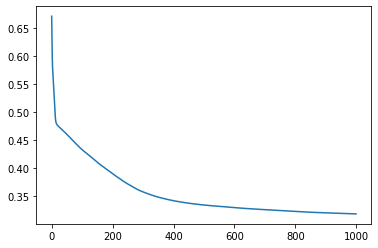

In [101]:
## Plot the model performance
plt.plot(np.arange(0, num_epochs, 1), mean_epoch_error_list)

In [102]:
print(np.max(layer_derivative_dict['dw3']))

0.007408125748201245


In [103]:
#### MNIST EXAMPLE ####

In [104]:
## load mnist data
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images / 255.0
test_images = test_images / 255.0
#print(train_images.shape)
#print(train_labels.shape)

In [105]:
## make a mlp to process them
N = 784
num_nes = [N, 40, 30, 20, 10]
num_layers = len(num_nes) - 1
learning_rate = 0.01
num_epochs = 10
threshold = 0.5

In [106]:
## initialize the layer derivative and in out dicts
## dict to hold neuron input-output pairs
layer_in_out_dict = dict()
## dict to hold the cost derivatives w.r.t to the params
layer_derivative_dict = dict()
## Initialize the weights
## the dict to hold the layer weights and biases
weight_dict = {'w'+str(i): np.random.normal(size=(num_nes[i+1], num_nes[i])) for i in range(num_layers)}
bias_dict = {'b'+str(i): np.random.normal(size=(num_nes[i+1], 1)) for i in range(num_layers)}

In [107]:
def onehot(label):
    ## make an empty vector
    onehot_label = np.zeros((num_nes[-1], 1))
    onehot_label[label] = 1
    return onehot_label

In [108]:
def infer(inputs):
    pred_list = list()
    for i in range(inputs.shape[0]):
        inp = np.expand_dims(inputs[i].flatten(), 1)
        #print(inp.shape)
        pred = predict(inp)
        #print(pred.shape)
        pred_list.append(np.swapaxes(pred, 0, 1))
    #print(np.array(pred_list).shape)
    return np.squeeze(np.swapaxes(np.array(pred_list), 0, 1), 0)

In [109]:
def accuracy(preds, target, is_validation=False):
    ## threshold the predictions to 0,1
    #print(targets.shape)
    #print(preds > 0.1)
    positive_preds = 0
    for i in range(preds.shape[1]):
        ## current pred boolean
        if is_validation:
            pred = preds[i][target[i]] > threshold
        else:
            pred = preds[target] > threshold
        if pred:
            positive_preds += 1
    return positive_preds / preds.shape[1]

In [110]:
mean_epoch_error_list = list()
mean_epoch_train_accuracy_list = list()
mean_epoch_test_accuracy_list = list()
for e in range(num_epochs):
    epoch_loss_list = list()
    train_epoch_accuracy_list = list()
    for i in range(train_images.shape[0]):
        inp = np.expand_dims(train_images[i].flatten(), 1)
        #print(inp.shape)
        out_true = onehot(train_labels[i])
        #print(out_true.shape)
        compute_grads(inp, out_true)
        update_param()
        out = predict(inp)
        error = np.mean(mse(out, out_true))
        epoch_loss_list.append(error)
        train_sample_accuracy = accuracy(out, train_labels[i])
        train_epoch_accuracy_list.append(train_sample_accuracy)
    
    mean_epoch_error = np.mean(np.array(epoch_loss_list))
    mean_epoch_error_list.append(mean_epoch_error)

    mean_epoch_train_accuracy = np.mean(np.array(train_epoch_accuracy_list))
    mean_epoch_train_accuracy_list.append(mean_epoch_train_accuracy)
    print("Epoch loss: {}".format(mean_epoch_error))
    print("Train accuracy: {}".format(mean_epoch_train_accuracy * 100.0))
    
    ## do a validation and get the accuracy
    test_preds = infer(test_images)
    #print(test_preds.shape)
    test_accuracy = accuracy(test_preds, test_labels, is_validation=True)
    mean_epoch_test_accuracy_list.append(test_accuracy)
    print("Test accuracy: {}".format(test_accuracy * 100.0))
    print("")

Epoch loss: 0.038920940763920484
Train accuracy: 12.768333333333334
Test accuracy: 40.0

Epoch loss: 0.026755131825060497
Train accuracy: 37.861666666666665
Test accuracy: 50.0

Epoch loss: 0.020553479283380954
Train accuracy: 56.96
Test accuracy: 50.0

Epoch loss: 0.016552841294468833
Train accuracy: 68.49
Test accuracy: 60.0

Epoch loss: 0.01379588743066835
Train accuracy: 75.49666666666667
Test accuracy: 80.0

Epoch loss: 0.011877207038970074
Train accuracy: 79.50833333333334
Test accuracy: 80.0

Epoch loss: 0.010567017109714912
Train accuracy: 82.03833333333334
Test accuracy: 80.0

Epoch loss: 0.009646793883170612
Train accuracy: 83.75
Test accuracy: 80.0

Epoch loss: 0.008964581949406497
Train accuracy: 85.0
Test accuracy: 80.0

Epoch loss: 0.00843017213130617
Train accuracy: 85.95333333333333
Test accuracy: 80.0



In [111]:
for j in range(len(num_nes)-1):
    for i, val in enumerate(layer_derivative_dict['dw'+str(j)]):
        #print(val)
        #print(i+1)
        ## count the neurons which has zero gradient
        zero_grads = len(list(filter(lambda x: True if x < 1e-10 else False, val)))
        print("Neuron ID: {}, number of zero gradients: {} out of {}".format(i+1, zero_grads, len(val)))
    print()

Neuron ID: 1, number of zero gradients: 784 out of 784
Neuron ID: 2, number of zero gradients: 641 out of 784
Neuron ID: 3, number of zero gradients: 784 out of 784
Neuron ID: 4, number of zero gradients: 784 out of 784
Neuron ID: 5, number of zero gradients: 784 out of 784
Neuron ID: 6, number of zero gradients: 784 out of 784
Neuron ID: 7, number of zero gradients: 641 out of 784
Neuron ID: 8, number of zero gradients: 784 out of 784
Neuron ID: 9, number of zero gradients: 641 out of 784
Neuron ID: 10, number of zero gradients: 784 out of 784
Neuron ID: 11, number of zero gradients: 641 out of 784
Neuron ID: 12, number of zero gradients: 641 out of 784
Neuron ID: 13, number of zero gradients: 731 out of 784
Neuron ID: 14, number of zero gradients: 724 out of 784
Neuron ID: 15, number of zero gradients: 641 out of 784
Neuron ID: 16, number of zero gradients: 641 out of 784
Neuron ID: 17, number of zero gradients: 784 out of 784
Neuron ID: 18, number of zero gradients: 784 out of 784
N

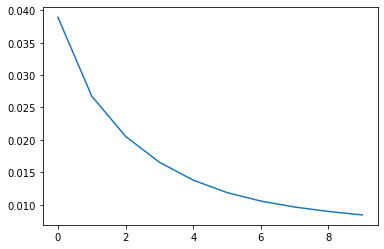

In [112]:
plt.plot(np.arange(0, num_epochs, 1), mean_epoch_error_list)

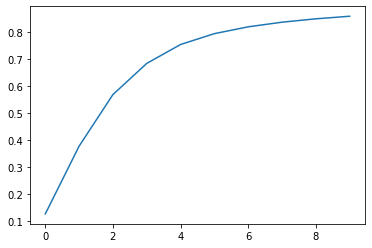

In [113]:
plt.plot(np.arange(0, num_epochs, 1), mean_epoch_train_accuracy_list)

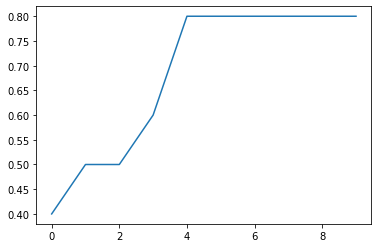

In [114]:
plt.plot(np.arange(0, num_epochs, 1), mean_epoch_test_accuracy_list)

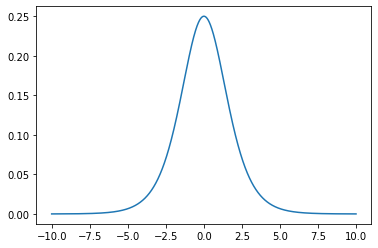

In [115]:
## check the sigmoid prime
X = np.arange(-10, 10, 0.01)
sp = list(map(lambda x: sigmoid_prime(x), X))
plt.plot(X, sp)